In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

In [2]:
STAD_mutation = pd.read_csv("/Users/shuhaoxu/Desktop/BNFO285/Groupproject/Project2/TCGA.STAD.mutations.txt", sep='\t')

In [3]:
mutation_matrix = pd.crosstab(
    index=STAD_mutation['patient_id'],
    columns=STAD_mutation['Hugo_Symbol'],
    values=1, 
    aggfunc='count'
)
mutation_matrix = mutation_matrix.fillna(0)

# random

In [4]:
reconstruction_errors = []
components_range = range(2, 5)

for n_components in components_range:
    model = NMF(n_components=n_components, init='random', random_state=42, max_iter=1000)
    W = model.fit_transform(mutation_matrix)
    H = model.components_
    
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(mutation_matrix - reconstructed)
    reconstruction_errors.append(error)

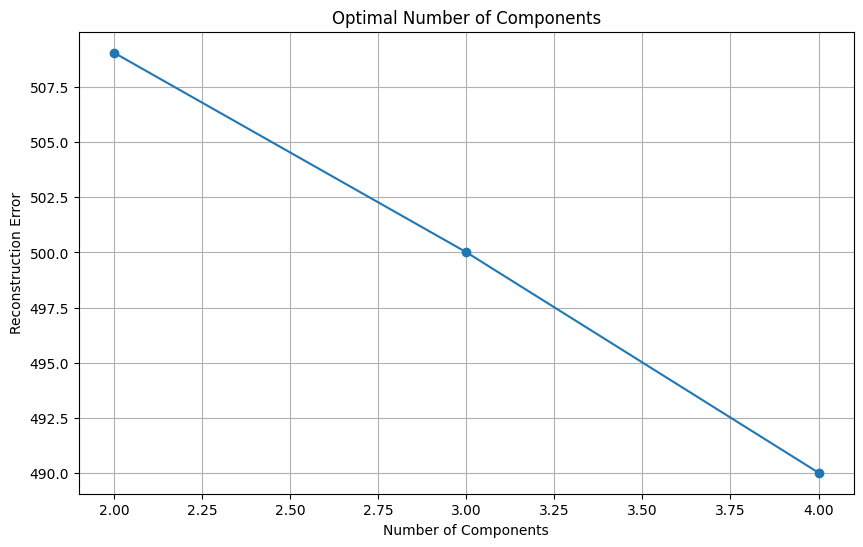

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Optimal Number of Components')
plt.grid(True)
plt.show()

# nndsvd

In [23]:
reconstruction_errors = []
components_range = range(2, 30)

for n_components in components_range:
    model = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=1000)
    W = model.fit_transform(mutation_matrix)
    H = model.components_
    
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(mutation_matrix - reconstructed)
    reconstruction_errors.append(error)

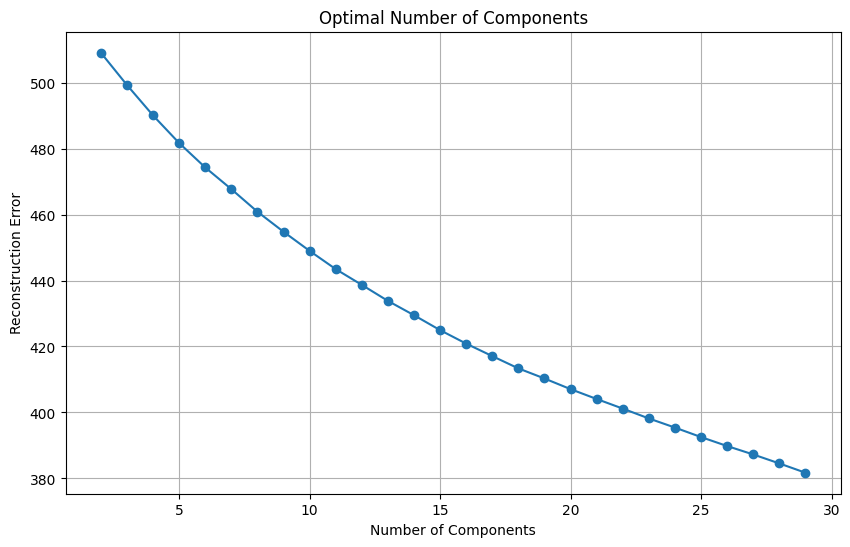

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Optimal Number of Components')
plt.grid(True)
plt.show()

# nndsvda

In [25]:
reconstruction_errors = []
components_range = range(2, 30)

for n_components in components_range:
    model = NMF(n_components=n_components, init='nndsvda', random_state=42, max_iter=1000)
    W = model.fit_transform(mutation_matrix)
    H = model.components_
    
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(mutation_matrix - reconstructed)
    reconstruction_errors.append(error)

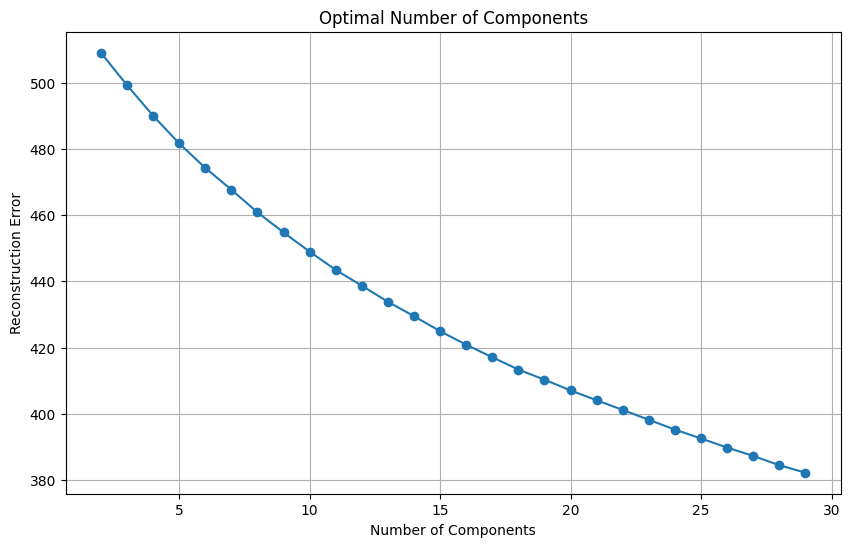

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Optimal Number of Components')
plt.grid(True)
plt.show()

# Test as many param as possible

In [36]:
def evaluate_nmf(data, components=5, init_method='random', 
                 beta_loss='frobenius', normalize_method=None):
    
    if normalize_method:
        if normalize_method == 'l1_sample':
            data_norm = normalize(data, norm='l1', axis=1)
        elif normalize_method == 'l2_sample':
            data_norm = normalize(data, norm='l2', axis=1)
        elif normalize_method == 'l1_gene':
            data_norm = normalize(data, norm='l1', axis=0)
        else:
            data_norm = data
    else:
        data_norm = data
    
    model = NMF(n_components=components, 
                init=init_method,
                beta_loss=beta_loss,
                random_state=0, 
                max_iter=2000,
                solver='mu')
    
    W = model.fit_transform(data_norm)
    H = model.components_
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(data_norm - reconstructed)
    
    return {
        'error': error,
        'iterations': model.n_iter_,
        'W': W,
        'H': H,
        'model': model
    }

In [37]:
results = []
for init in ['random', 'nndsvd']:
    for beta in ['frobenius', 'kullback-leibler']:
        for norm in [None, 'l1_sample', 'l2_sample']:
            result = evaluate_nmf(mutation_matrix, 
                                  components=5,
                                  init_method=init,
                                  beta_loss=beta,
                                  normalize_method=norm)
            results.append({
                'init': init,
                'beta_loss': beta,
                'normalization': norm,
                'error': result['error'],
                'iterations': result['iterations']
            })
            
results_df = pd.DataFrame(results)

/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' o

In [38]:
results_df

,init,beta_loss,normalization,error,iterations
0,random,frobenius,None,481.807432,100
1,random,frobenius,l1_sample,1.828991,20
2,random,frobenius,l2_sample,19.560877,70
3,random,kullback-leibler,None,511.316652,130
4,random,kullback-leibler,l1_sample,2.349999,80
5,random,kullback-leibler,l2_sample,19.719020,110
6,nndsvd,frobenius,None,486.587470,40
7,nndsvd,frobenius,l1_sample,1.828991,20
8,nndsvd,frobenius,l2_sample,19.586669,30
9,nndsvd,kullback-leibler,None,515.505200,60


# Optimal parameters

In [42]:
optimal_components = 5
mutation_matrix_norm = normalize(mutation_matrix, norm='l1', axis=1)
final_model = NMF(n_components=optimal_components, init='nndsvd', beta_loss="frobenius", random_state=0, max_iter=2000)
W = final_model.fit_transform(mutation_matrix_norm)
H = final_model.components_
feature_importance = pd.DataFrame(H, columns=mutation_matrix.columns)

In [43]:
feature_importance

Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,hsa-mir-490,hsa-mir-6080,snoU13
0,3.200267e-09,4.789892e-09,1.400636e-07,2.628355e-07,2.666926e-10,1.257440e-10,2.523254e-10,6.661011e-08,6.648247e-08,1.693892e-10,...,2.412022e-09,1.058120e-09,6.723495e-08,2.839619e-09,3.900093e-10,6.232150e-09,1.463771e-09,1.093220e-09,3.250416e-07,8.361252e-11
1,3.291819e-06,3.228567e-06,1.069979e-05,5.904241e-06,6.190997e-07,1.191549e-06,2.179668e-06,2.455888e-06,3.294206e-06,1.981688e-06,...,3.742424e-06,2.160897e-06,5.340282e-06,3.503509e-06,2.507225e-07,3.370028e-05,1.503172e-06,8.517219e-07,1.758540e-06,3.126935e-08
2,5.467044e-07,1.359884e-06,3.911925e-06,2.661351e-05,4.304946e-07,2.306330e-07,3.745707e-08,5.999823e-07,1.623405e-06,4.597870e-07,...,6.931829e-07,1.807378e-06,1.226421e-05,5.875488e-07,9.793850e-07,3.107310e-06,5.378012e-07,2.513517e-07,3.497399e-07,1.222790e-08
3,7.892548e-05,1.163001e-04,2.617224e-04,1.596322e-04,7.094360e-06,3.109686e-06,7.978161e-06,3.036039e-05,8.814524e-05,3.730745e-06,...,1.296307e-04,2.860305e-05,5.802358e-05,7.363161e-05,1.056580e-05,1.982164e-04,4.585745e-05,3.768799e-05,3.475438e-05,2.114638e-06
4,3.362013e-05,1.242539e-04,1.985797e-04,1.066299e-04,5.118966e-06,1.212908e-06,5.859782e-06,1.248965e-05,6.800178e-05,2.062001e-06,...,2.714686e-05,3.895132e-05,1.393737e-04,2.880453e-05,8.558302e-06,7.619020e-05,1.958181e-05,1.673032e-05,1.765297e-05,2.251675e-06


# Preliminary

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

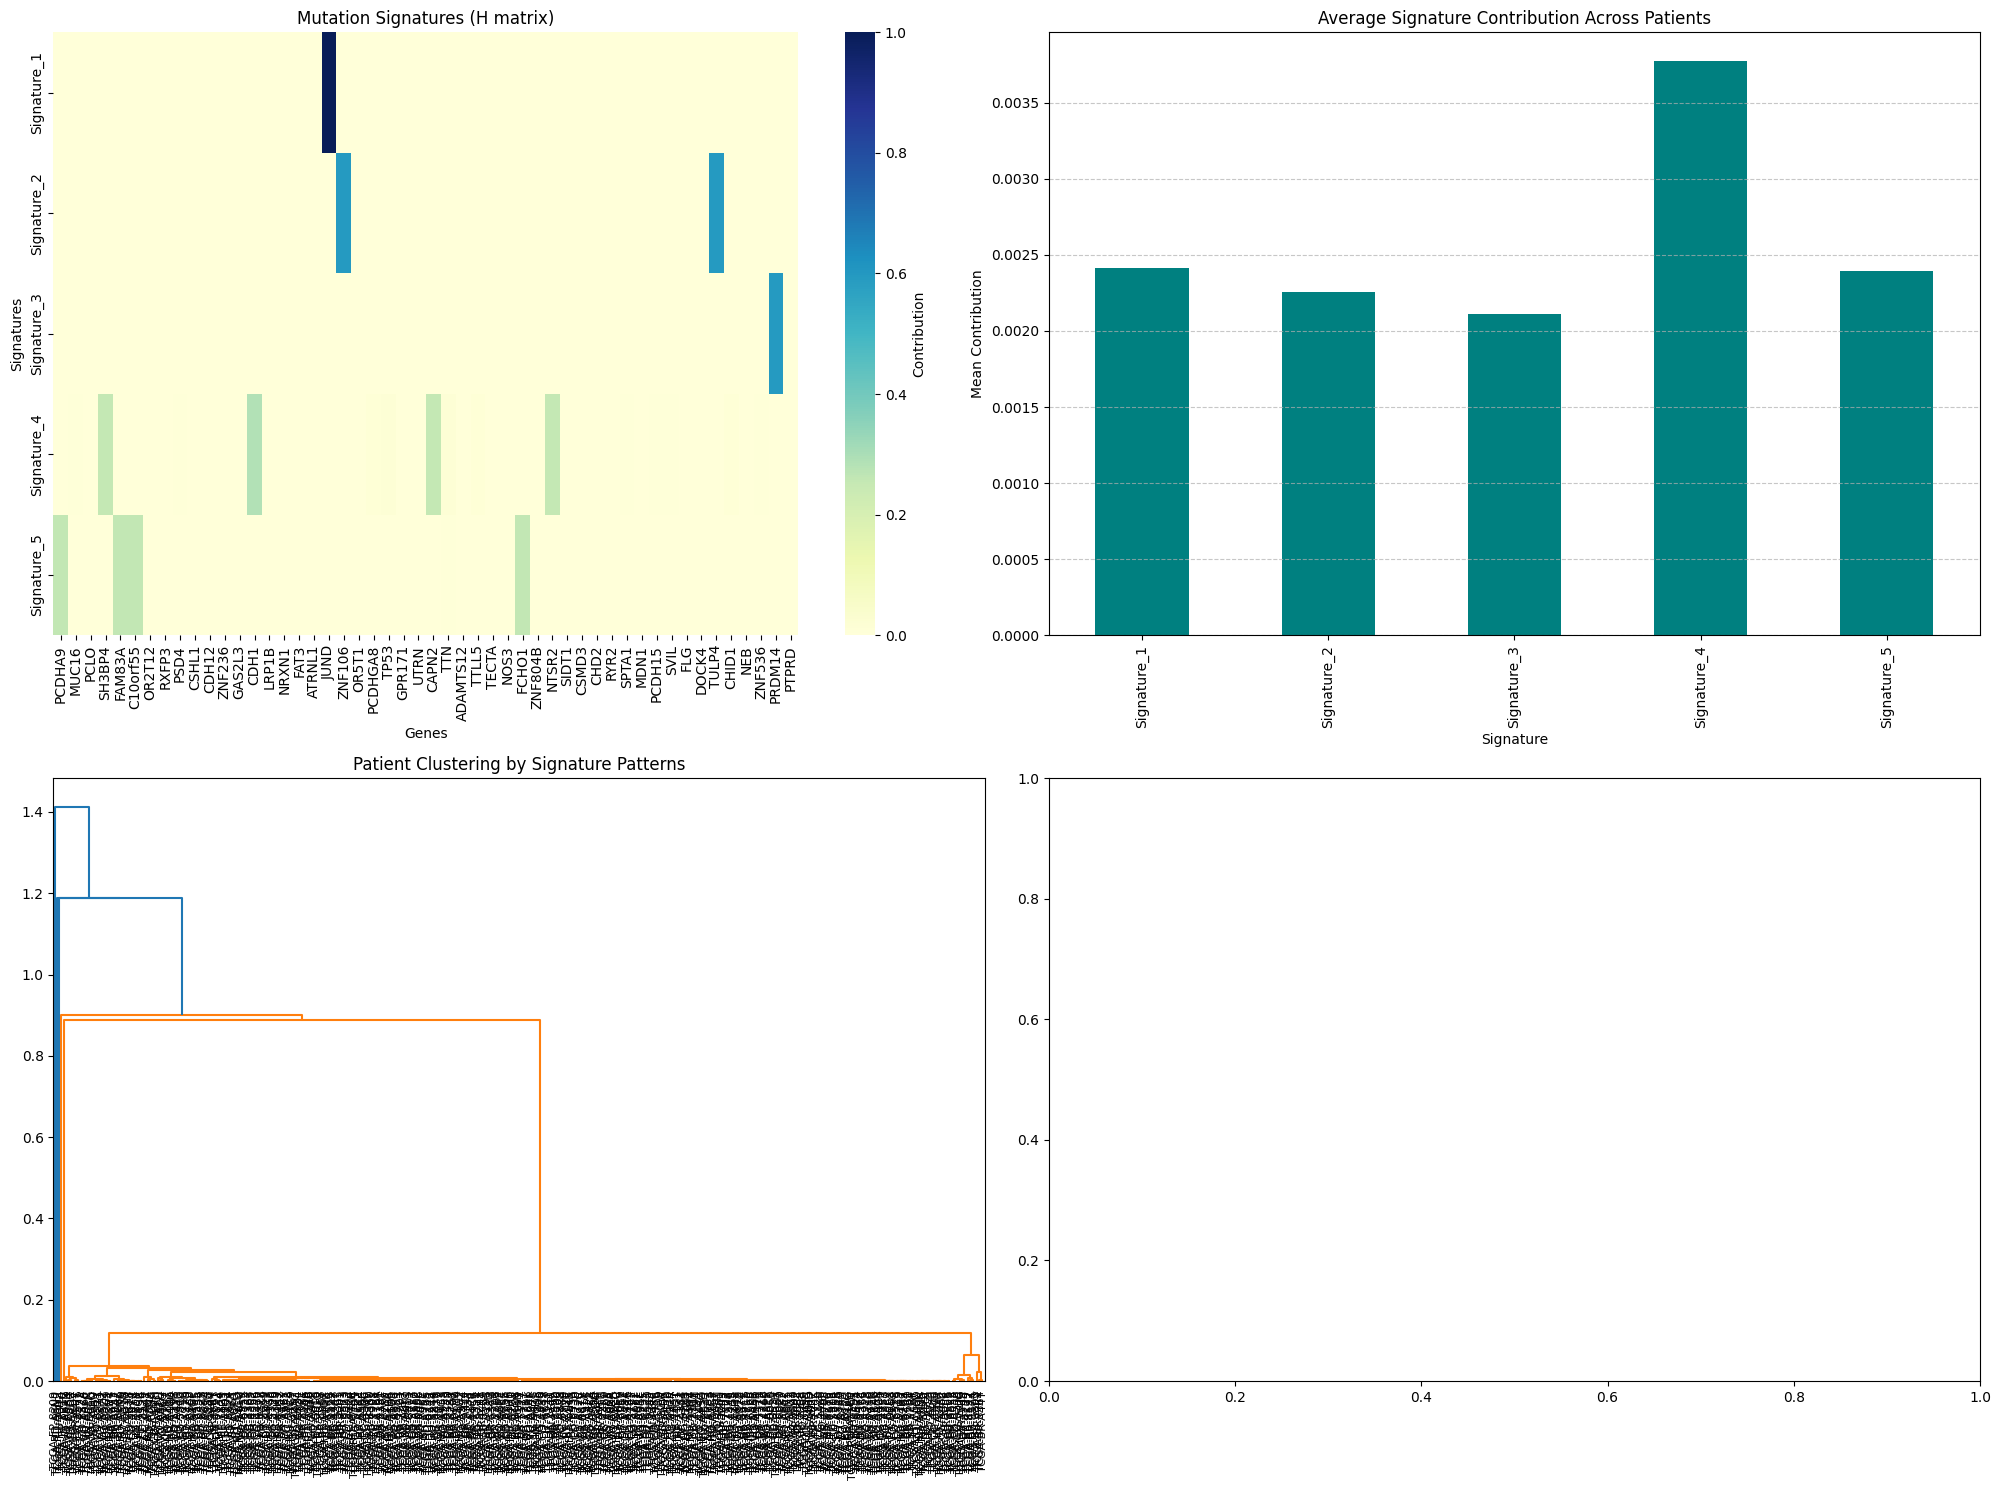

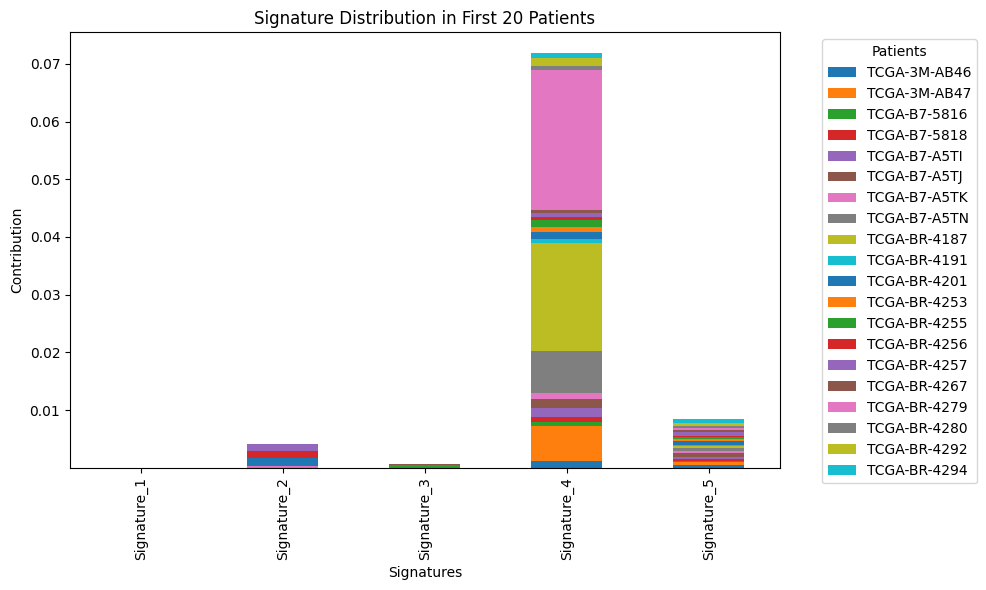

/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_71684/2256494083.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_gene_values.index[:15], y=top_gene_values.values[:15], palette="viridis")
/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_71684/2256494083.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_gene_values.index[:15], y=top_gene_values.values[:15], palette="viridis")
/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_71684/2256494083.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(

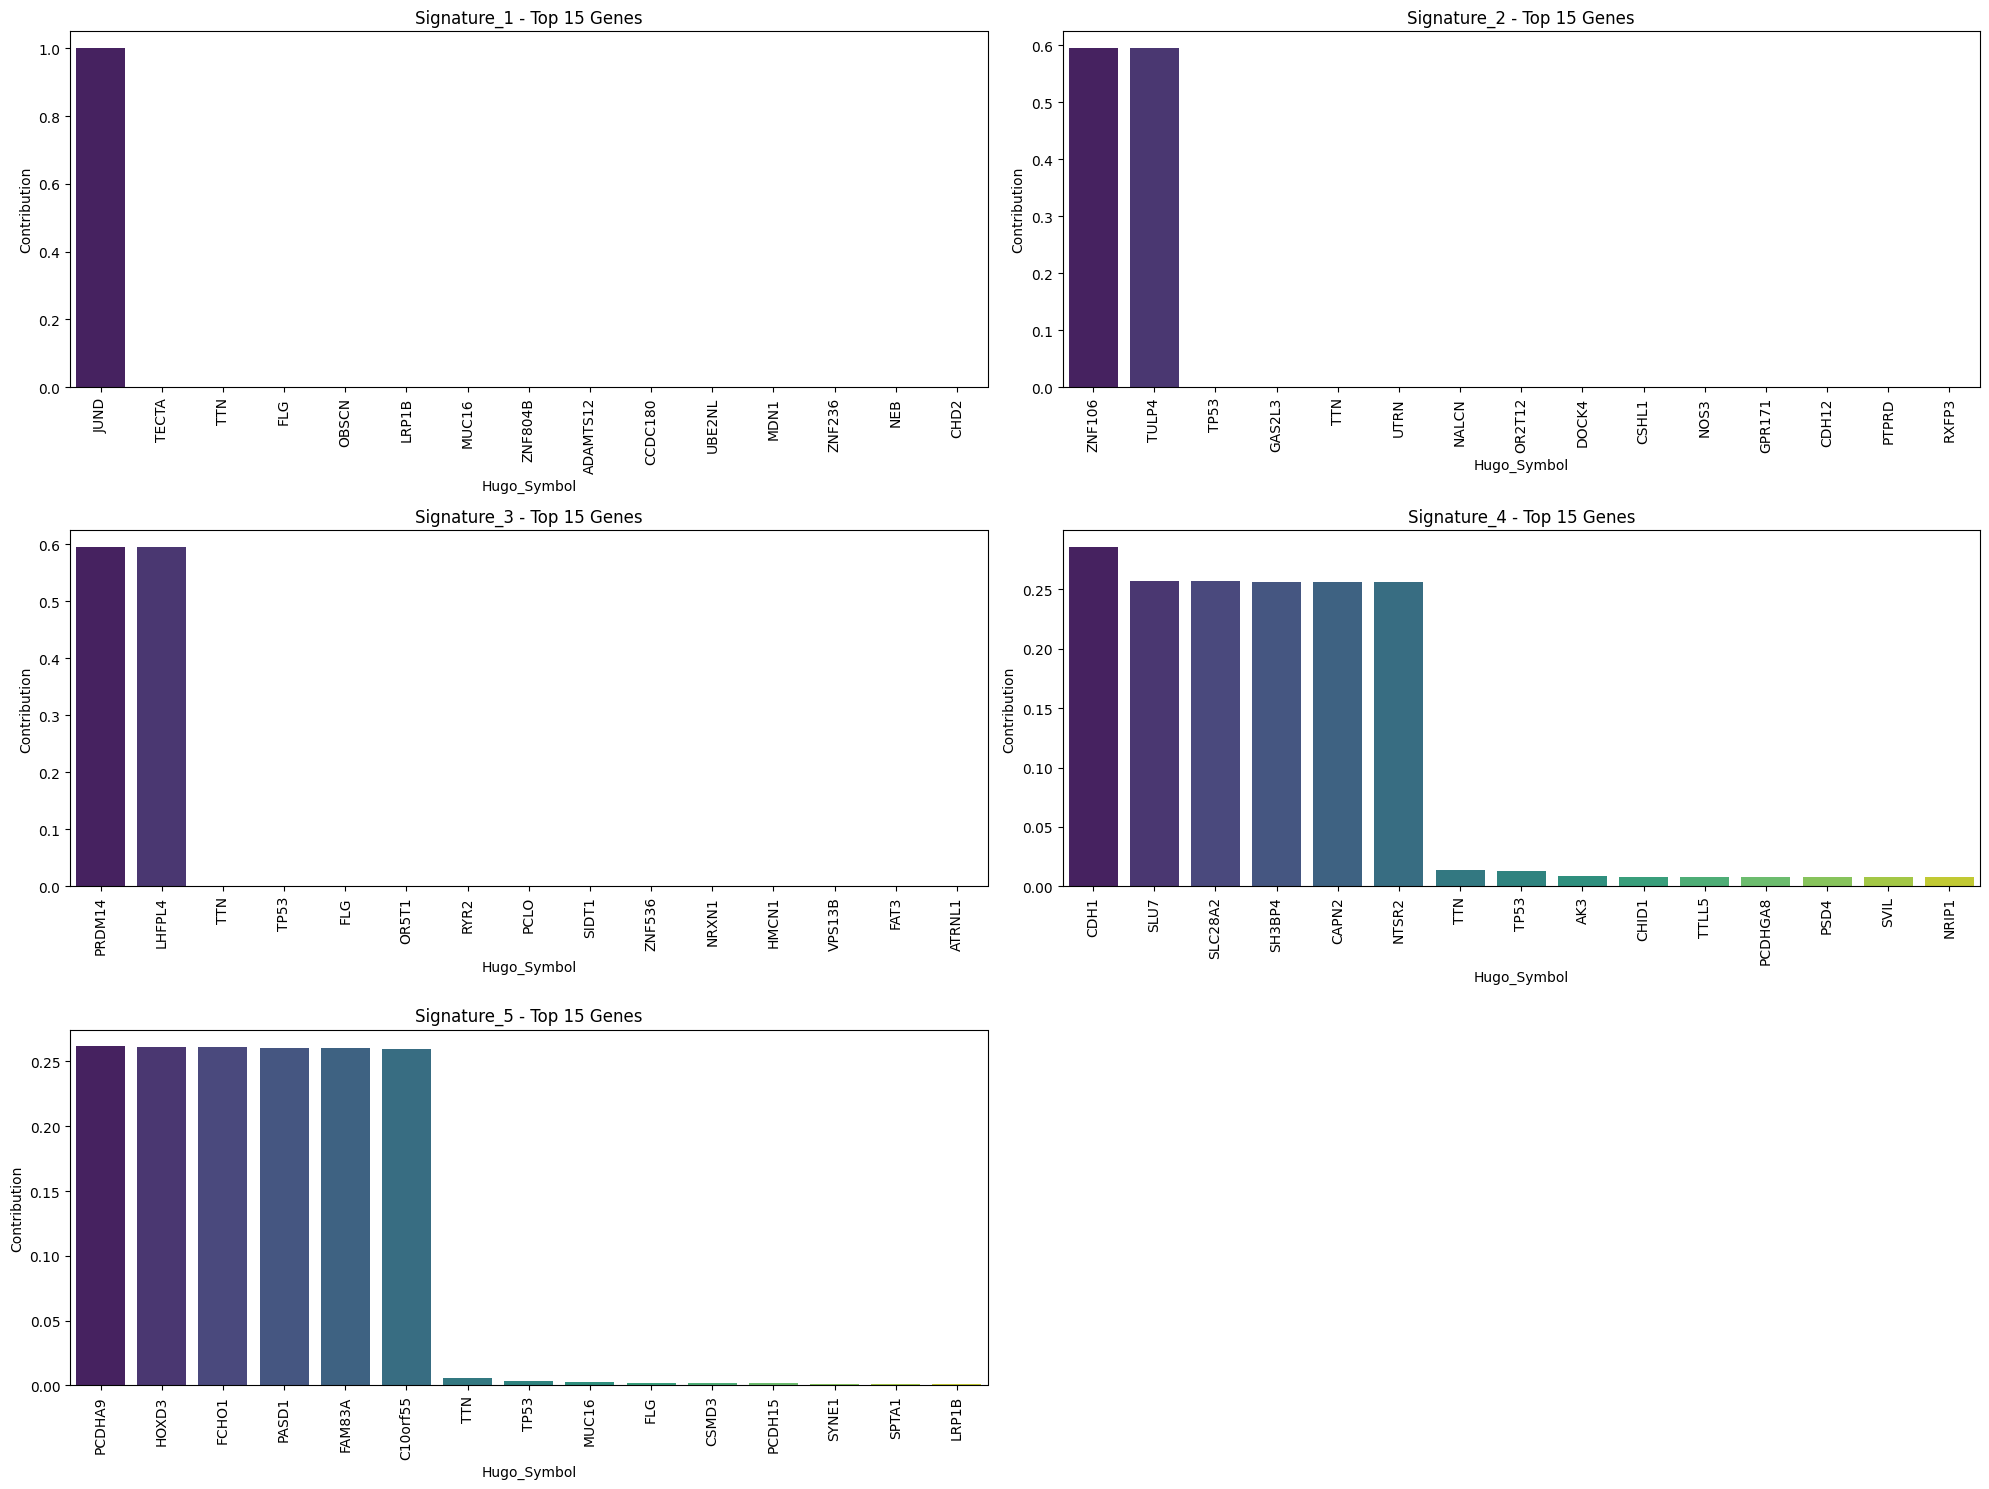

In [48]:
def analyze_signatures(H, mutation_matrix, top_n=20):
    signatures = pd.DataFrame(H, columns=mutation_matrix.columns)
    signatures.index = [f"Signature_{i+1}" for i in range(signatures.shape[0])]
    top_genes = {}
    for i, signature in enumerate(signatures.index):
        sorted_genes = signatures.iloc[i].sort_values(ascending=False)
        top_genes[signature] = sorted_genes.head(top_n)
    return signatures, top_genes

def analyze_patient_associations(W, mutation_matrix_norm, mutation_matrix):
    patient_signatures = pd.DataFrame(
        W, index=mutation_matrix.index,
        columns=[f"Signature_{i+1}" for i in range(W.shape[1])])
    
    patient_signatures['Dominant_Signature'] = patient_signatures.idxmax(axis=1)
    signature_counts = patient_signatures['Dominant_Signature'].value_counts()
    return patient_signatures

def visualize_nmf_results(signatures, patient_signatures, top_genes):
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    top_50_genes = set()
    for sig in signatures.index:
        top_50_genes.update(top_genes[sig].head(15).index)
    top_50_genes = list(top_50_genes)[:50]

    sns.heatmap(
        signatures[top_50_genes],
        cmap="YlGnBu",
        yticklabels=signatures.index,
        xticklabels=True,
        cbar_kws={"label": "Contribution"}
    )
    plt.title("Mutation Signatures (H matrix)")
    plt.xlabel("Genes")
    plt.ylabel("Signatures")
    plt.xticks(rotation=90)
    
    plt.subplot(2, 2, 2)
    sig_means = patient_signatures.drop('Dominant_Signature', axis=1).mean()
    sig_means.plot(kind='bar', color='teal')
    plt.title("Average Signature Contribution Across Patients")
    plt.xlabel("Signature")
    plt.ylabel("Mean Contribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 3)
    patient_sig_data = patient_signatures.drop('Dominant_Signature', axis=1)
    Z = linkage(patient_sig_data, 'ward')
    dendrogram(Z, labels=patient_sig_data.index, leaf_rotation=90, leaf_font_size=8)
    plt.title("Patient Clustering by Signature Patterns")
    plt.tight_layout()
    
    plt.subplot(2, 2, 4)
    patient_sig_data.iloc[:20].T.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title("Signature Distribution in First 20 Patients")
    plt.xlabel("Signatures")
    plt.ylabel("Contribution")
    plt.legend(title="Patients", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    # plt.savefig("nmf_mutation_signatures.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(20, 15))
    for i, sig in enumerate(signatures.index):
        plt.subplot(3, 2, i+1)
        top_gene_values = top_genes[sig].sort_values(ascending=False)
        sns.barplot(x=top_gene_values.index[:15], y=top_gene_values.values[:15], palette="viridis")
        plt.title(f"{sig} - Top 15 Genes")
        plt.xticks(rotation=90)
        plt.ylabel("Contribution")
    
    plt.tight_layout()
    # plt.savefig("signature_top_genes.png", dpi=300, bbox_inches='tight')
    plt.show()

def biological_interpretation(signatures, top_genes):
    signature_interpretations = {}

    for sig in signatures.index:
        signature_interpretations[sig] = {
            'top_genes': list(top_genes[sig].head(10).index),
            'potential_pathways': [],
            'biological_processes': [],
            'similar_known_signatures': [],
            'notes': ''
        }
    return signature_interpretations


signatures, top_genes = analyze_signatures(H, mutation_matrix)
patient_signatures = analyze_patient_associations(W, mutation_matrix_norm, mutation_matrix)
visualize_nmf_results(signatures, patient_signatures, top_genes)
signature_interpretations = biological_interpretation(signatures, top_genes)

results =  {
        'signatures': signatures,
        'patient_signatures': patient_signatures,
        'top_genes': top_genes,
        'interpretations': signature_interpretations
    }

# Separate by models

In [6]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
df = pd.read_csv("/Users/shuhaoxu/Desktop/BNFO285/Groupproject/Project2/TCGA.STAD.mutations.txt", sep="\t")

Log10 split: 2.858
Exact split: 721 mutations


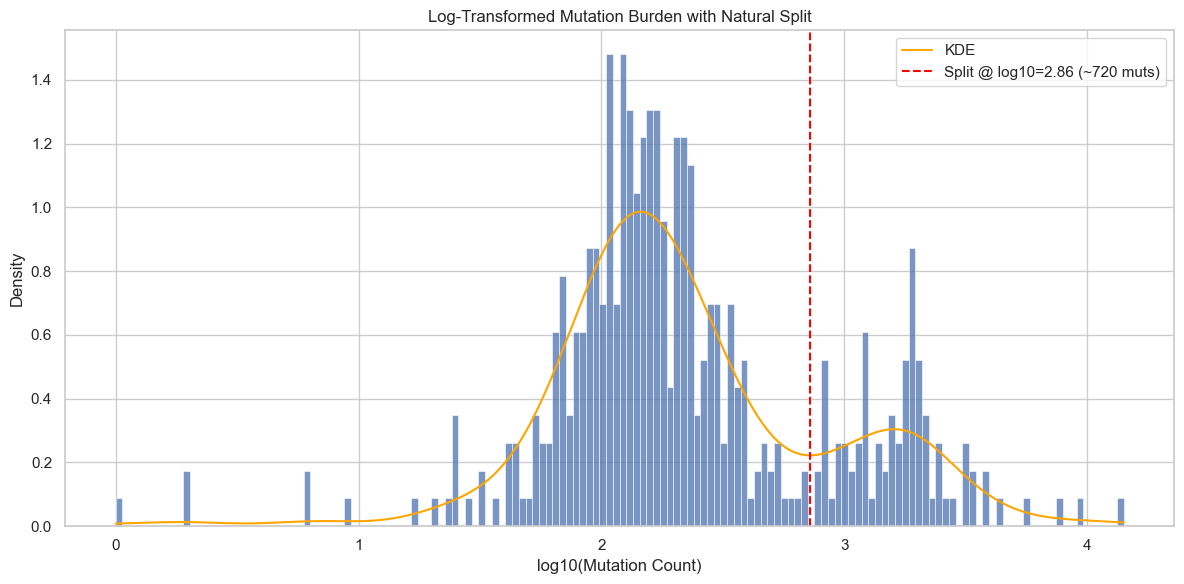

In [8]:
mutation_counts = df['patient_id'].value_counts().sort_index()
counts_array = mutation_counts[mutation_counts > 0].values.astype(float)
log_counts = np.log10(counts_array)

kde = gaussian_kde(log_counts)
x_vals = np.linspace(log_counts.min(), log_counts.max(), 1000)
kde_vals = kde(x_vals)
mask = (x_vals > 1.5) & (x_vals < 3.5)
x_zoom = x_vals[mask]
kde_zoom = kde_vals[mask]

# Find trough (local minimum)
troughs, _ = find_peaks(-kde_zoom)
if len(troughs) > 0:
    log_split = x_zoom[troughs[0]]
    exact_split = 10**log_split
    print(f"Log10 split: {log_split:.3f}")
    print(f"Exact split: {exact_split:.0f} mutations")
else:
    log_split = None
    print("No trough found.")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(log_counts, bins=150, kde=False, stat="density")
plt.plot(x_vals, kde_vals, color='orange', label='KDE')

# Plot vertical line for the split
if log_split:
    plt.axvline(log_split, color='red', linestyle='--', label=f"Split @ log10={log_split:.2f} (~{int(exact_split)} muts)")

plt.xlabel("log10(Mutation Count)")
plt.ylabel("Density")
plt.title("Log-Transformed Mutation Burden with Natural Split")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Get histogram bin edges from the KDE-aligned plot
hist_bins = np.histogram_bin_edges(log_counts, bins=50)

# Convert log bins to linear mutation counts
linear_bins = 10 ** hist_bins

# Find the largest bin edge that is still less than the exact split
bin_aligned_split = linear_bins[linear_bins < exact_split].max()

print(f"Adjusted split (previous bin edge): {bin_aligned_split:.0f} mutations")

Adjusted split (previous bin edge): 663 mutations


In [11]:
threshold = bin_aligned_split
mutation_counts = df['patient_id'].value_counts().sort_index()
mutation_split_df = mutation_counts.to_frame(name="mutation_count")

# Assign groups
mutation_split_df["mutation_group"] = mutation_split_df["mutation_count"].apply(
    lambda x: "High" if x >= threshold else "Low"
)

# Split into patient ID lists
low_patients = mutation_split_df[mutation_split_df["mutation_group"] == "Low"].index.tolist()
high_patients = mutation_split_df[mutation_split_df["mutation_group"] == "High"].index.tolist()

# Filter original mutation rows
low_mut = df[df['patient_id'].isin(low_patients)]
high_mut = df[df['patient_id'].isin(high_patients)]

# Build mutation matrix
def build_mutation_matrix(df, context_col="CONTEXT", sample_col="patient_id"):
    mutation_matrix = (
        df.groupby([sample_col, context_col])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )
    return mutation_matrix

In [164]:
def reverse_complement(seq):
    comp_dict = {"A": "T", "C": "G", "T": "A", "G": "C"}
    seq_rev = seq[::-1]
    seq_rev_comp = ""
    for letter in seq_rev:
        seq_rev_comp += comp_dict[letter]
    return seq_rev_comp

def standardize_to_pyrimidine(context_ref, context_mut):
    center_base = context_ref[1]
    if center_base in ['A', 'G']:
        comp_dict = {"A": "T", "C": "G", "T": "A", "G": "C"}
        rev_comp_ref = "".join([comp_dict[base] for base in context_ref[::-1]])
        rev_comp_mut = "".join([comp_dict[base] for base in context_mut[::-1]])
        return rev_comp_ref, rev_comp_mut
    else:
        return context_ref, context_mut

low_mut_filt = low_mut[low_mut.Variant_Type == "SNP"][['patient_id', 'Hugo_Symbol', 'STRAND', 'Reference_Allele', 'Tumor_Seq_Allele2', 'CONTEXT']]
high_mut_filt = high_mut[high_mut.Variant_Type == "SNP"][['patient_id', 'Hugo_Symbol', 'STRAND', 'Reference_Allele', 'Tumor_Seq_Allele2', 'CONTEXT']]

low_mut_filt["context_corrected"] = low_mut_filt.apply(
    lambda row: reverse_complement(row["CONTEXT"]) if row["STRAND"] == -1 else row["CONTEXT"],
    axis=1
)
high_mut_filt["context_corrected"] = high_mut_filt.apply(
    lambda row: reverse_complement(row["CONTEXT"]) if row["STRAND"] == -1 else row["CONTEXT"],
    axis=1
)

low_mut_filt["ref_corrected"] = low_mut_filt.apply(
    lambda row: reverse_complement(row["Reference_Allele"]) if row["STRAND"] == -1 else row["Reference_Allele"],
    axis=1
)
high_mut_filt["ref_corrected"] = high_mut_filt.apply(
    lambda row: reverse_complement(row["Reference_Allele"]) if row["STRAND"] == -1 else row["Reference_Allele"],
    axis=1
)

low_mut_filt["mut_corrected"] = low_mut_filt.apply(
    lambda row: reverse_complement(row["Tumor_Seq_Allele2"]) if row["STRAND"] == -1 else row["Tumor_Seq_Allele2"],
    axis=1
)
high_mut_filt["mut_corrected"] = high_mut_filt.apply(
    lambda row: reverse_complement(row["Tumor_Seq_Allele2"]) if row["STRAND"] == -1 else row["Tumor_Seq_Allele2"],
    axis=1
)


In [165]:
high_mut_filt["context_tri_ref"] = high_mut_filt["context_corrected"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])
low_mut_filt["context_tri_ref"] = low_mut_filt["context_corrected"].apply(lambda x: x[(len(x)-3)//2:(len(x)-3)//2+3])

low_mut_filt["context_tri_mut"] = low_mut_filt["context_tri_ref"].str[0] + low_mut_filt["mut_corrected"].str[0] + low_mut_filt["context_tri_ref"].str[2]
high_mut_filt["context_tri_mut"] = high_mut_filt["context_tri_ref"].str[0] + high_mut_filt["mut_corrected"].str[0] + high_mut_filt["context_tri_ref"].str[2]

low_mut_filt[['std_context_tri_ref', 'std_context_tri_mut']] = low_mut_filt.apply(
    lambda row: standardize_to_pyrimidine(row['context_tri_ref'], row['context_tri_mut']), 
    axis=1, result_type='expand'
)
low_mut_filt["mutation_types"] = low_mut_filt["std_context_tri_ref"].astype(str).str[0] + "[" + low_mut_filt["std_context_tri_ref"].astype(str).str[1] + ">" + low_mut_filt["std_context_tri_mut"].astype(str).str[1] + "]" + low_mut_filt["std_context_tri_mut"].astype(str).str[2]

high_mut_filt[['std_context_tri_ref', 'std_context_tri_mut']] = high_mut_filt.apply(
    lambda row: standardize_to_pyrimidine(row['context_tri_ref'], row['context_tri_mut']), 
    axis=1, result_type='expand'
)
high_mut_filt["mutation_types"] = high_mut_filt["std_context_tri_ref"].astype(str).str[0] + "[" + high_mut_filt["std_context_tri_ref"].astype(str).str[1] + ">" + high_mut_filt["std_context_tri_mut"].astype(str).str[1] + "]" + high_mut_filt["std_context_tri_mut"].astype(str).str[2]

In [166]:
low_matrix = build_mutation_matrix(low_mut_filt, context_col = "mutation_types")
high_matrix = build_mutation_matrix(high_mut_filt, context_col = "mutation_types")

In [170]:
low_matrix_T = low_matrix.T
high_matrix_T = high_matrix.T

In [174]:
high_matrix_T.shape

(96, 86)

In [175]:
low_matrix_T.shape

(96, 329)

# SigProfiler

In [120]:
from SigProfilerExtractor import sigpro as sig

In [177]:
high_matrix_T = high_matrix_T.reset_index(names="mutation_types")
# high_matrix_T = high_matrix_T.drop(columns=["patient_id"])
high_matrix_T.head()

patient_id,mutation_types,TCGA-B7-5816,TCGA-B7-A5TI,TCGA-BR-4201,TCGA-BR-4256,TCGA-BR-4257,TCGA-BR-4280,TCGA-BR-4292,TCGA-BR-4361,TCGA-BR-4362,...,TCGA-VQ-A8P2,TCGA-VQ-A8PB,TCGA-VQ-A8PO,TCGA-VQ-A8PP,TCGA-VQ-A8PX,TCGA-VQ-A91D,TCGA-VQ-A91E,TCGA-VQ-A91K,TCGA-VQ-A924,TCGA-VQ-AA6D
0,A[C>A]A,3,1,1,2,1,0,2,4,4,...,3,3,0,0,0,2,1,8,2,2
1,A[C>A]C,5,0,4,1,3,0,3,5,1,...,27,1,3,2,3,4,3,6,2,0
2,A[C>A]G,0,0,0,0,1,2,3,2,2,...,1,0,1,0,1,0,0,3,0,0
3,A[C>A]T,1,3,4,3,1,0,5,1,1,...,57,1,1,5,1,1,4,9,3,2
4,A[C>G]A,5,1,2,2,1,1,3,7,1,...,8,1,0,0,0,1,0,3,1,2


In [179]:
high_matrix_T = high_matrix_T.fillna(0)

In [180]:
sig.sigProfilerExtractor("matrix", "High", high_matrix_T, opportunity_genome="GRCh38", exome=True)




************** Reported Current Memory Use: 0.82 GB *****************

Extracting signature 1 for mutation type 96
The matrix normalizing cutoff is 9600


process 1 continues please wait... 
execution time: 2 seconds 

process 1 continues please wait... 
execution time: 2 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 continues please wait... 
execution time: 2 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 continues please wait... 
execution time: 2 seconds 

process 1 continues please wait... 
execution time: 2 seconds 

process 1 continues please wait... 
execution time: 2 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 continues please wait... 
execution time: 1 seconds 

process 1 co

In [181]:
low_matrix_T = low_matrix_T.fillna(0)

sig.sigProfilerExtractor("matrix", "Low", low_matrix_T, opportunity_genome="GRCh38", exome=True)


************** Reported Current Memory Use: 0.12 GB *****************

Extracting signature 1 for mutation type 96
The matrix normalizing cutoff is 9600


process 1 continues please wait... 
execution time: 4 seconds 

process 1 continues please wait... 
execution time: 4 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 4 seconds 

process 1 continues please wait... 
execution time: 4 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 continues please wait... 
execution time: 3 seconds 

process 1 co